# This notebook is for BGS specific results

In [1]:
import numpy as np
import fitsio
from matplotlib import pyplot as plt
import os

In [2]:
ff = fitsio.read('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/BGS_ANYAlltiles_full.dat.fits')

total number of unique reachable BGS targets is 189448
total number of unique observed BGS targets is 132615
total number of unique BGS targets with good redshifts is 131585
targeting completeness is 0.7000073898906296
redshift success rate is 0.992233156128643


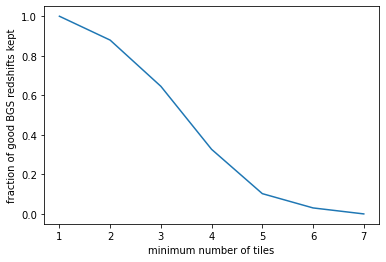

In [3]:
print('total number of unique reachable BGS targets is '+str(len(ff)))
wo = ff['LOCATION_ASSIGNED'] == 1
print('total number of unique observed BGS targets is '+str(len(ff[wo])))
wz = ff['ZWARN'] == 0
print('total number of unique BGS targets with good redshifts is '+str(len(ff[wz])))
print('targeting completeness is '+str(len(ff[wo])/len(ff)))
print('redshift success rate is '+str(len(ff[wz])/len(ff[wo])))
ngl = [len(ff[wz])]
ntm = [1]
for nt in range(1,7):
    wt = ff['NTILE'] > nt
    ntm.append(nt+1)
    ngl.append(len(ff[wz&wt]))
plt.plot(ntm,np.array(ngl)/len(ff[wz]))
plt.xlabel('minimum number of tiles')
plt.ylabel('fraction of good BGS redshifts kept')
plt.show()


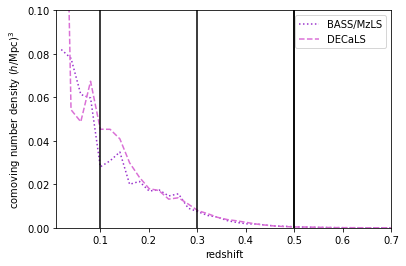

In [6]:
#plot n(z)
nz = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/BGS_ANY_N_nz.dat').transpose()
plt.plot(nz[0],nz[3],':',color='darkorchid',label='BASS/MzLS')
nz = np.loadtxt('/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/LSScats/test/BGS_ANY_S_nz.dat').transpose()
plt.plot(nz[0],nz[3],'--',color='orchid',label='DECaLS')
plt.legend()
plt.xlim(0.01,0.7)
plt.ylim(0,0.1)
xl = [0.1,0.1]
yl = [0,0.1]
plt.plot(xl,yl,'k-')
xl = [0.3,0.3]
yl = [0,0.1]
plt.plot(xl,yl,'k-')
xl = [0.5,0.5]
yl = [0,0.1]
plt.plot(xl,yl,'k-')
plt.plot(xl,yl,'k-')
plt.xlabel('redshift')
plt.ylabel(r'comoving number density ($h$/Mpc)$^3$')
plt.show()

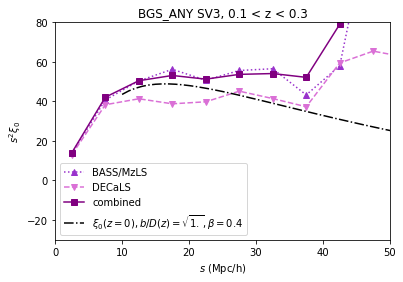

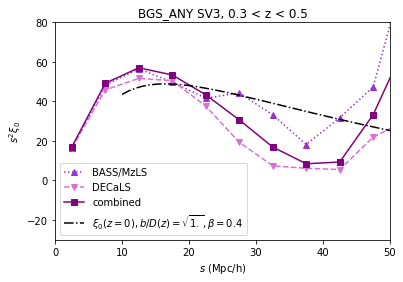

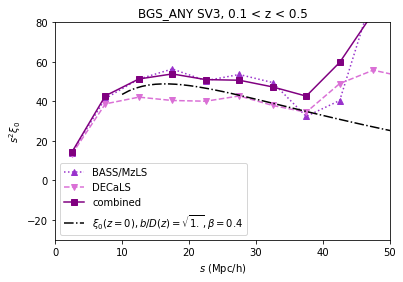

In [8]:
zl = [0.1,0.3,0.5]
for i in range(0,len(zl)):
    if i == len(zl)-1:
        zmin=zl[0]
        zmax=zl[-1]
    else:
        zmin = zl[i]
        zmax = zl[i+1]

    xils = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testBGS_ANY_S'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    xil = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testBGS_ANY'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    xiln = np.loadtxt('/global/cscratch1/sd/ajross/SV3xi/xi024SV3_testBGS_ANY_N'+str(zmin)+str(zmax)+'5st0.dat').transpose()
    plt.plot(xil[0],xil[0]**2.*xiln[1],'^:',color='darkorchid',label='BASS/MzLS')
    plt.plot(xil[0],xil[0]**2.*xils[1],'v--',color='orchid',label='DECaLS')
    plt.plot(xil[0],xil[0]**2.*xil[1],'s-',color='purple',label='combined')
    xilin = np.loadtxt(os.environ['HOME']+'/BAOtemplates/xi0Challenge_matterpower0.44.04.08.015.00.dat').transpose()
    plt.plot(xilin[0],xilin[0]**2.*xilin[1]*1.,'k-.',label=r'$\xi_{\rm 0}(z=0),b/D(z)=\sqrt{1.},\beta=0.4$')

    plt.title('BGS_ANY SV3, '+str(zmin)+' < z < '+str(zmax))
    plt.xlim(0,50)
    plt.ylim(-30,80)
    plt.xlabel(r'$s$ (Mpc/h)')
    plt.ylabel(r'$s^2\xi_0$')
    plt.legend()
    plt.show()

## wacky thing